In [330]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

In [331]:
def show_img(image):
    plt.figure(figsize=(16,16))
    plt.imshow(image)

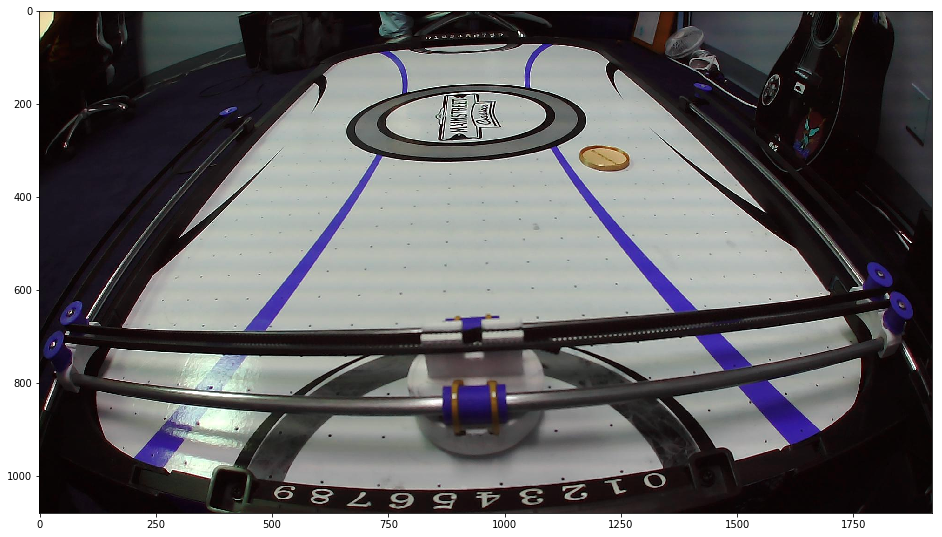

In [508]:
image=cv2.imread("Center_4.jpg")
orig = image.copy()
show_img(image)

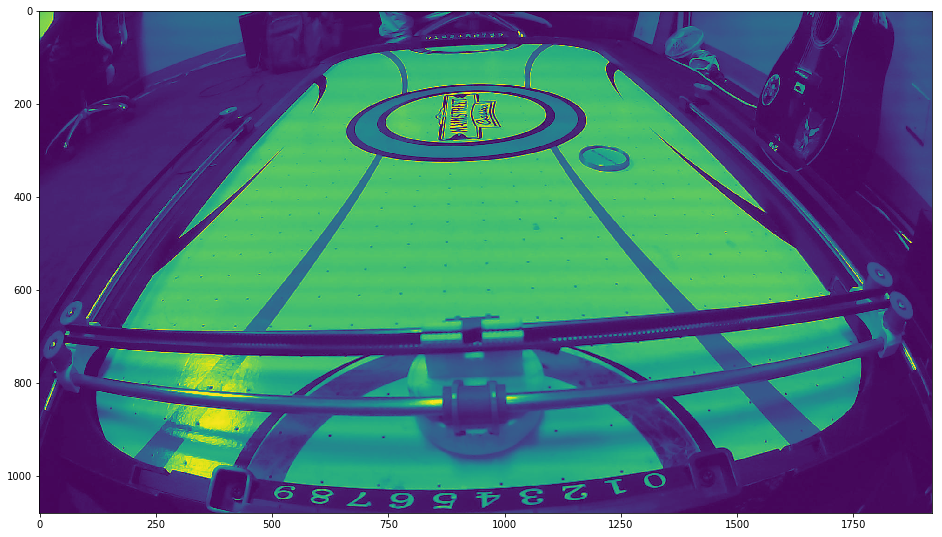

In [509]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_img(gray)

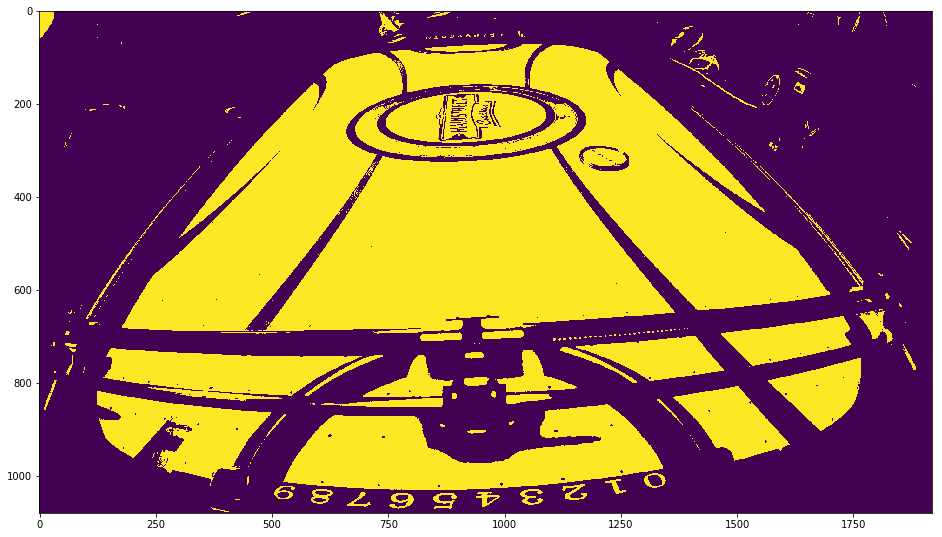

In [510]:
# Apply threshold to grayscale img. (Converts to b&w)
t, bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
show_img(bw)

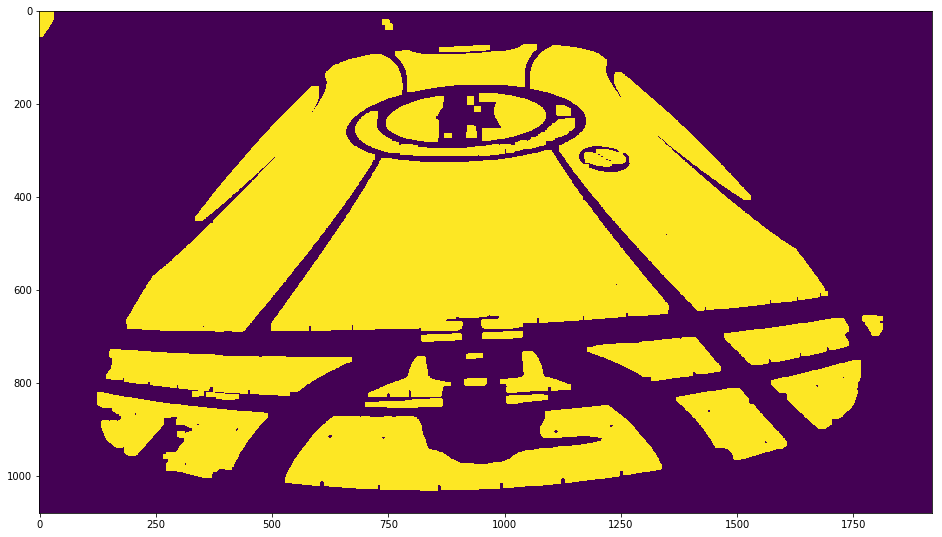

In [511]:
# we only want large objects since we are trying to detect
# the board. 1x60 is a good starting point. Can call again
# with override if the result is not good enough.
# this cleans up the outside noise
opened=cv2.morphologyEx(bw,cv2.MORPH_OPEN, np.ones((10,15)))
show_img(opened)

Kernel: (1, 65)


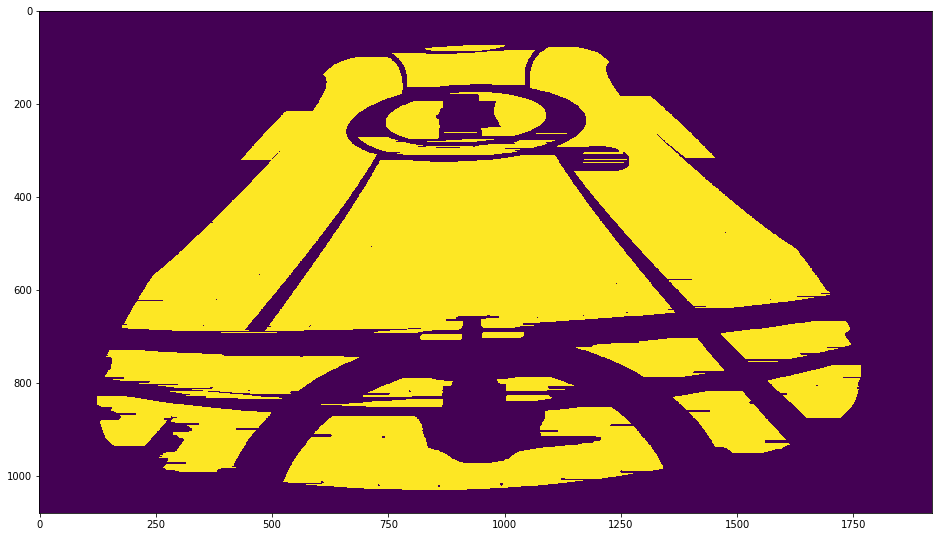

In [512]:
kernel1=1
kernel2=60
while True:    
    kernel = np.ones((kernel1,kernel2))
    opened=cv2.morphologyEx(bw,cv2.MORPH_OPEN, kernel)    

    zero_count_l=np.count_nonzero(opened[:,:120])
    zero_count_r=np.count_nonzero(opened[:,1780:])
    if zero_count_l > 0 or zero_count_r > 0:
        #kernel1+=1 
        kernel2+=1
    else:
        print "Kernel:",(kernel1,kernel2)
        break

show_img(opened)

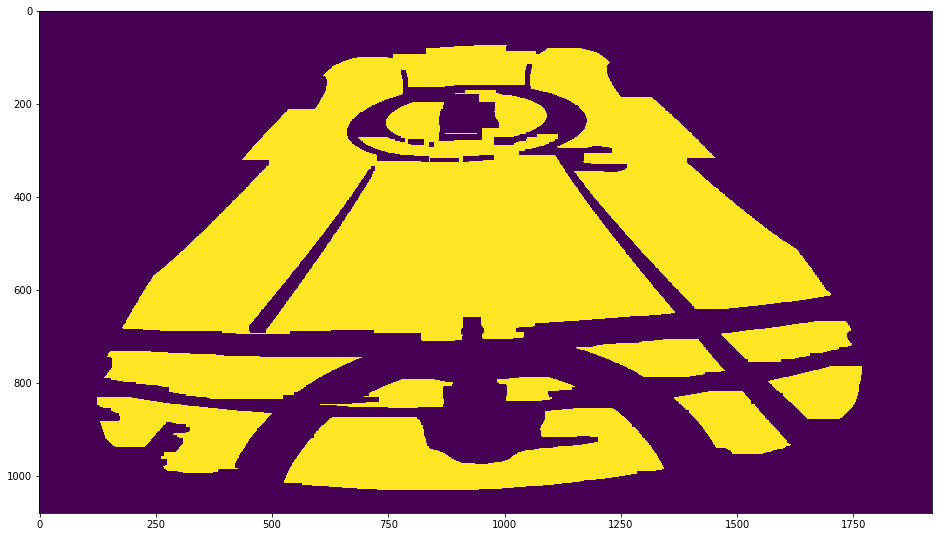

In [513]:
# this cleans up the noise on the inside and reduces the number of
# objects.
closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((10,10)))
show_img(closed)

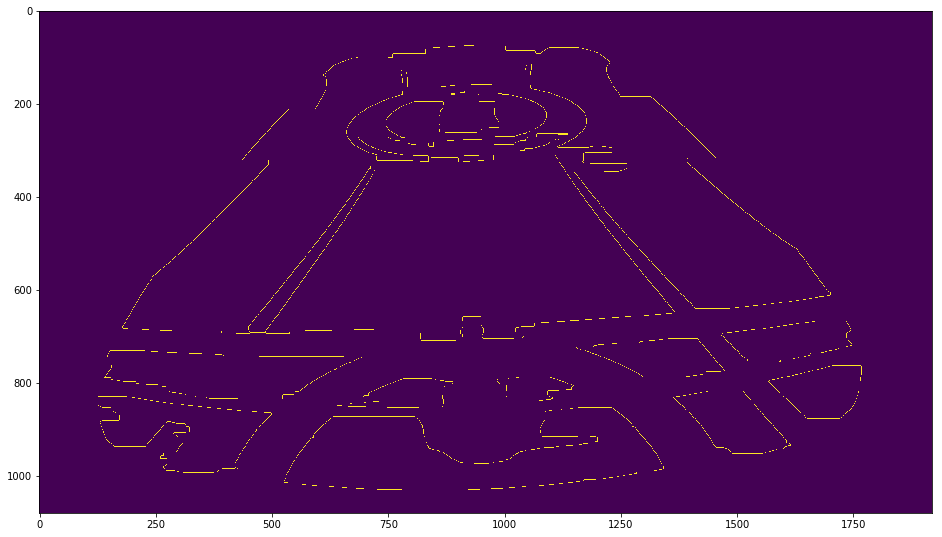

In [514]:
edges = cv2.Canny(closed,1,1)
show_img(edges)

In [515]:
from scipy.spatial import ConvexHull
xs, ys = np.where(edges > 0)
edgePts=np.array(zip(ys,xs))

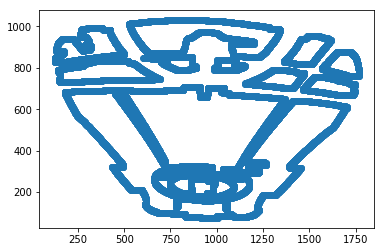

In [516]:
plt.scatter(ys,xs)

In [517]:
    rect = cv2.minAreaRect(edgePts)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

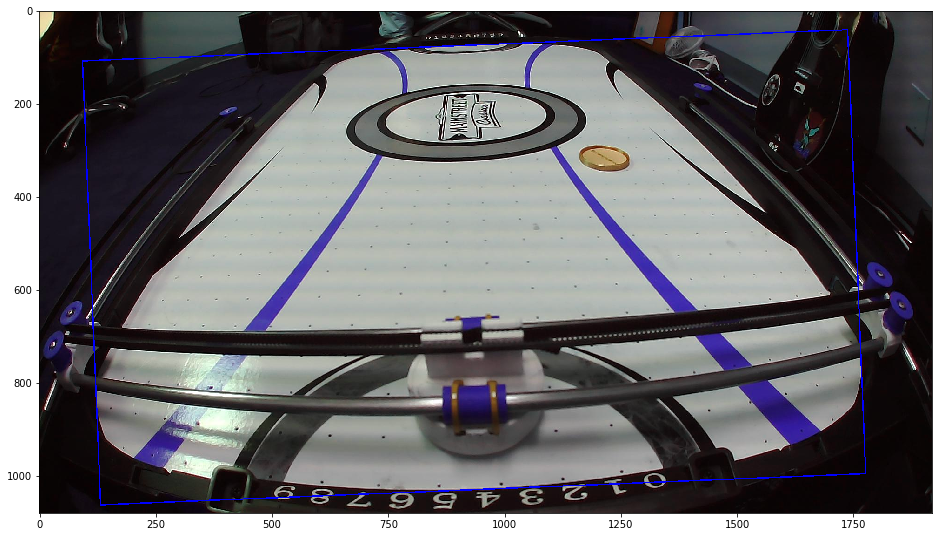

In [518]:
disp=orig.copy()
cv2.drawContours(disp,[box],0,(0,0,255),2)
show_img(disp)

# convert points to tuple
rect_bot_left=tuple(box[0])
rect_top_left=tuple(box[1])
rect_top_right=tuple(box[2])
rect_bot_right=tuple(box[3])

In [519]:
a, triangle = cv2.minEnclosingTriangle(np.array([edgePts]))

In [520]:
print triangle


[[[ -138.82192993  1073.31921387]]

 [[ 2047.83813477   984.06781006]]

 [[  907.8692627   -298.39709473]]]


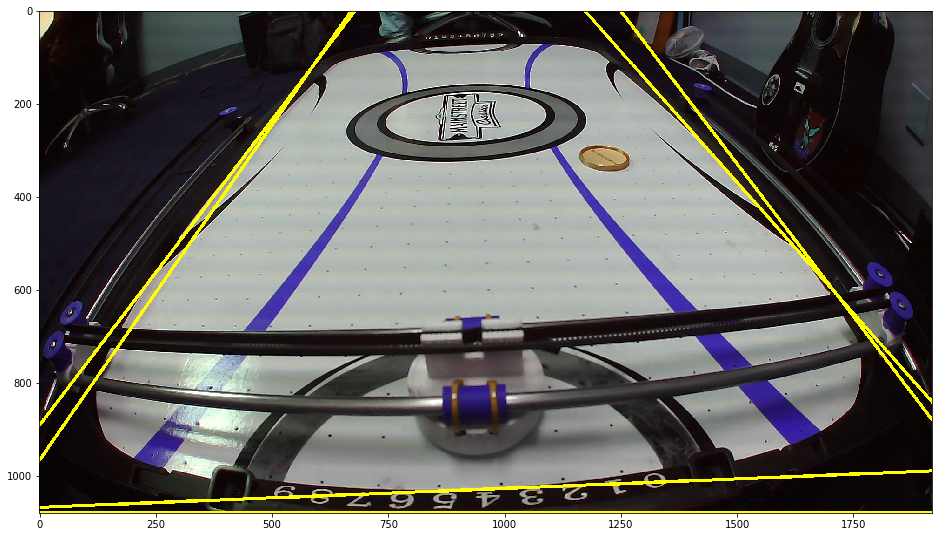

In [521]:
disp=orig.copy()
img = cv2.line(triangle_disp, (triangle[0][0][0],triangle[0][0][1]), (triangle[1][0][0], triangle[1][0][1]), (255,255,0), 5)
img = cv2.line(triangle_disp, (triangle[1][0][0],triangle[1][0][1]), (triangle[2][0][0], triangle[2][0][1]), (255,255,0), 5)
img = cv2.line(triangle_disp, (triangle[2][0][0],triangle[2][0][1]), (triangle[0][0][0], triangle[0][0][1]), (255,255,0), 5)

show_img(triangle_disp)

In [522]:
from __future__ import division 

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

In [523]:
tri_t=triangle[0]
tri_l=triangle[0]
tri_r=triangle[0]


for i in range(len(triangle)):
    if triangle[i][0][1] < tri_t[0][1]:
        tri_t=triangle[i]
        
    if triangle[i][0][0] < tri_l[0][0]:
        tri_l=triangle[i]
        
    if triangle[i][0][0] > tri_r[0][0]:
        tri_r=triangle[i]
        
        
print "tri_t:",tuple(tri_t[0])
print "tri_l:",tuple(tri_l[0])
print "tri_r:",tuple(tri_r[0])

tri_t: (907.86926, -298.39709)
tri_l: (-138.82193, 1073.3192)
tri_r: (2047.8381, 984.06781)


In [524]:
# Convert the points to tuple
tri_bot_right=tuple(tri_r[0])
tri_top=tuple(tri_t[0])
tri_bot_left=tuple(tri_l[0])

rect_top=line(rect_top_left, rect_top_right)
tri_left=line(tri_bot_left, tri_top)
tri_right=line(tri_bot_right, tri_top)

l_intersection=intersection(rect_top, tri_left)
r_intersection=intersection(rect_top, tri_right)

In [525]:
r_intersection

(1228.8768294922911, 62.736323662016105)

In [526]:
l_intersection

(613.17020923445045, 87.813736158840015)

In [527]:
homography_points = np.array([
    (int(tri_bot_left[0]), int(tri_bot_left[1])),
    (int(tri_bot_right[0]), int(tri_bot_right[1])),
    (int(r_intersection[0]), int(r_intersection[1])),
    (int(l_intersection[0]), int(l_intersection[1]))
])

In [528]:
homography_points

array([[-138, 1073],
       [2047,  984],
       [1228,   62],
       [ 613,   87]])

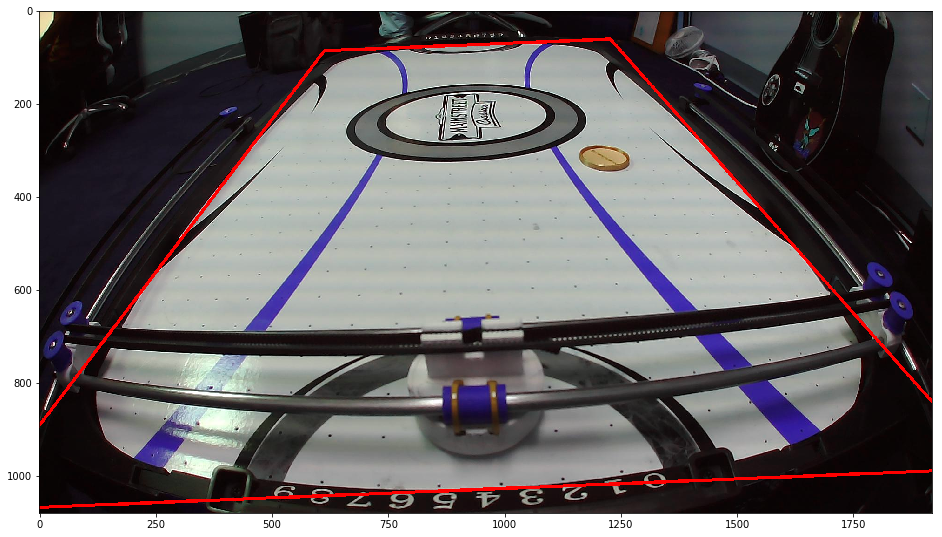

In [529]:
points_img = orig.copy()
img = cv2.polylines(points_img, [homography_points], True, (255, 0, 0), 5)

show_img(points_img)

In [530]:
pts_src = np.array(
    [
        homography_points[0],
        homography_points[1],
        homography_points[2],
        homography_points[3]
    ]
)

pts_dst = np.array(
    [
        [0, 639],
        [479, 639],
        [479, 0],
        [0, 0]        
    ]
)

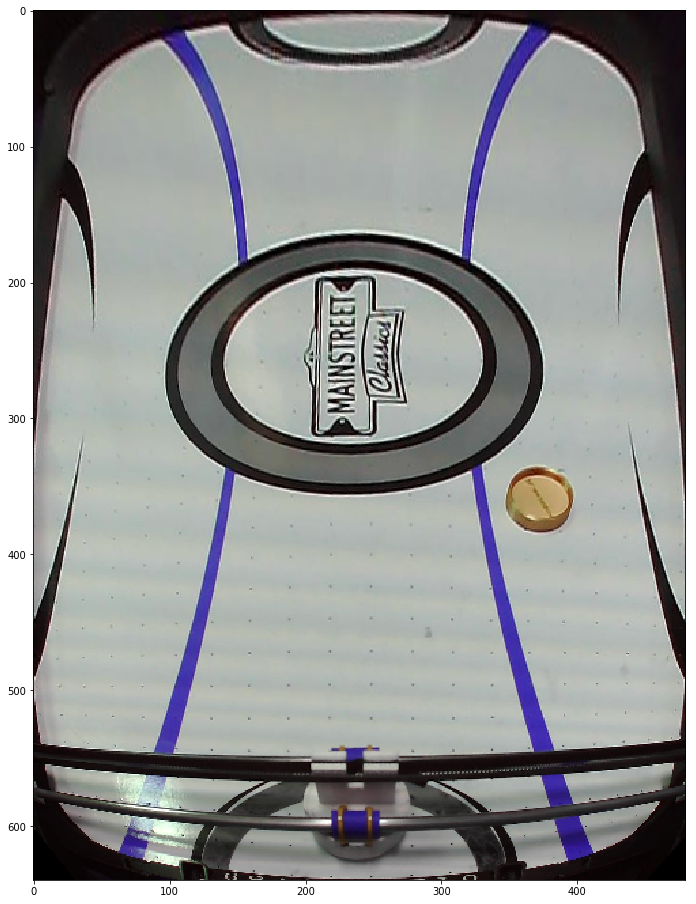

In [531]:
warped_img=orig.copy()
h, status = cv2.findHomography(pts_src, pts_dst)
warped = cv2.warpPerspective(warped_img, h, (480, 640))

show_img(warped)